## Embedded Faults (interface2d) 

* Setting up interface2D objects
* setting proximity and orientation on global swarm


In [1]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
import operator
import UWsubduction as usub

In [2]:
#Set up a box to play with

minX = -1.0
maxX = 1.0
resX = 12
resY = 6
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, -0.5), 
                                 maxCoord    = ( maxX, 0.5),
                                 periodic    = [False, False]  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

velocityField.data[:] = [0.,0.]


In [3]:
coordinate = fn.input()
yFn = coordinate[1]
xFn= coordinate[0]

In [4]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [6]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=False)
proximityVariable = swarm.add_variable( dataType="int", count=1 )
directorVariable   = swarm.add_variable( dataType="double", count=2)

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=50 )
swarm.populate_using_layout( layout=swarmLayout )

proximityVariable.data[:] = 0
directorVariable .data[:] = (0.0, 0.0)

In [7]:
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]

markerXs = np.linspace(-1.2, 1.2, 40)
markerYs = np.linspace(-0.6, 0.6, 40)


markerThickness = 0.1

line1 = usub.interface2D(mesh, velocityField, markerXs, markerYs, 
                        markerThickness, 1, insidePt=(0.,-10.))

line2 = usub.interface2D(mesh, velocityField, markerXs, -1.*markerYs, 
                        markerThickness, 2, insidePt=(0.,-10.))


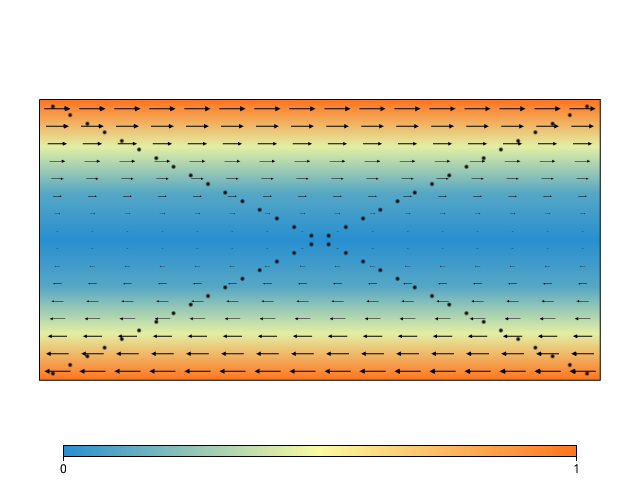

In [8]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=.1) )
fig1.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)) )
fig1.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig1.append( glucifer.objects.Points(line2.swarm, pointsize = 5))

fig1.show()

In [11]:

proximity, fpts = line2.compute_interface_proximity(swarm.particleCoordinates.data,  distance = 0.2)
sd, fpts = line2.compute_signed_distance(swarm.particleCoordinates.data, distance = 0.2)

truncatefn  = 0.125*fn.math.cos(2.*xFn) - 0.2
dat = truncatefn.evaluate(swarm)

mask = np.logical_and(sd < 0, sd > dat)
proximityVariable.data[mask ] = proximity[mask ]

In [12]:
dat

array([[-0.23244143],
       [-0.24237695],
       [-0.22228076],
       ..., 
       [-0.23712127],
       [-0.22705723],
       [-0.24692768]])


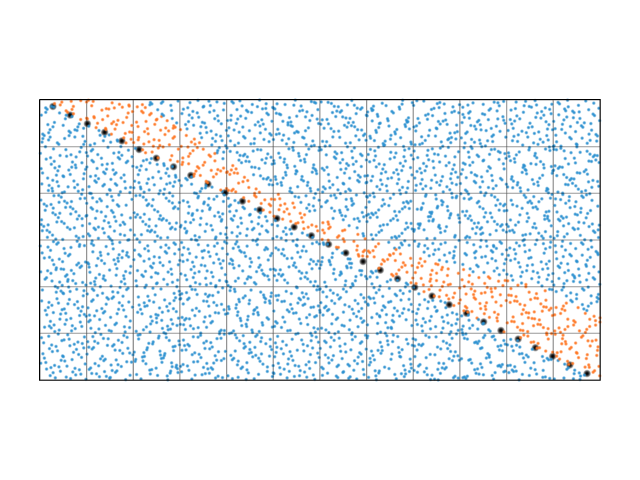

In [13]:
fig2 = glucifer.Figure(quality=3)
fig2.append( glucifer.objects.Points(swarm, proximityVariable, pointsize = 4, colourBar=False, quality=3))
#fig2.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig2.append(glucifer.objects.Mesh(mesh, opacity= 0.4)) 
fig2.append( glucifer.objects.Points(line2.swarm, pointsize = 8, marker =5, quality=3))


fig2.show()

In [15]:
#fig2.save_image('figs/demo.png')
#fig2.save_database('figs/demo.gldb')

In [16]:
minDistFn = fn.misc.constant(1.)
minDistFn = 3.*fn.math.abs(fn.math.cos(4.*coordinate[0]))


maxDistFn = 4.*fn.math.abs(coordinate[0])


In [17]:
proximityVariable.data[:] = 0


In [15]:
#import types

#meth = types.MethodType(f, C(), C)

#markerLine2D.proximity_director = proximity_director

In [19]:
dummy = line1.set_proximity_director(swarm, proximityVariable, searchFac = 2., 
                                     locFac=1.0, directorVar=directorVariable)

In [20]:
dummy = line2.set_proximity_director(swarm, proximityVariable, searchFac = 2., 
                                     locFac=1.0, directorVar=directorVariable)

In [21]:
#directorVariable.data[mask ] = dv[mask]

In [22]:
#dv[mask]


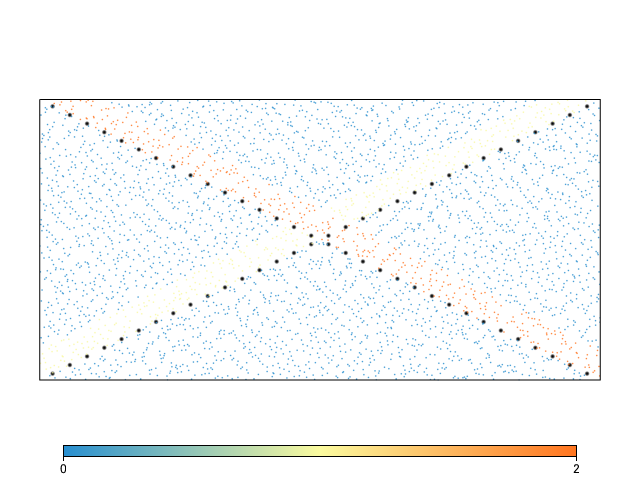

In [23]:
fig3 = glucifer.Figure()
fig3.append( glucifer.objects.Points(swarm, proximityVariable, pointsize = 2))
fig3.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig3.append( glucifer.objects.Points(line2.swarm, pointsize = 5))
fig3.show()

## Strain rate components

In [26]:
#If there is just one marker line, we can use:
#edotn_SFn, edots_SFn = line1.local_strainrate_fns( velocityField, directorVariable, proximityVariable)

#However, if there are two markerlines it's better to put them in a collection and do this

line_coll = usub.interface_collection([line1, line2])

edotn_SFn, edots_SFn = line_coll.global_line_strainrate_fns( velocityField, directorVariable, proximityVariable)


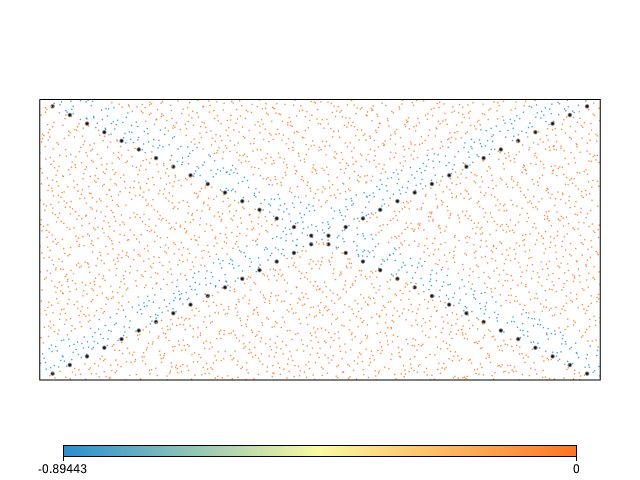

In [27]:
#

fig4 = glucifer.Figure()
#fig4.append( glucifer.objects.Points(swarm, fn.math.sqrt(edots_SFn**2 + edotn_SFn**2), pointsize = 2))
fig4.append( glucifer.objects.Points(swarm, directorVariable[1], pointsize = 2))

fig4.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig4.append( glucifer.objects.Points(line2.swarm, pointsize = 5))
fig4.show()

## Healing

In [28]:
from unsupported_dan.interfaces.smoothing2D import *

ImportError: No module named 'unsupported_dan'

In [24]:
np.unique(line1.swarm.particleCoordinates.data[:,0]).shape

(40,)

In [25]:
#line1.rebuild()
out = shadowMask(line1)


In [26]:
ds = 1.6/40.
A = line1.neighbourMatrix(k =4, jitter=1e-8)
midPoints, currentIds = neighbourDistanceQuery(line1, A, _lowdist=0.,_updist= 5.5*ds)

In [27]:
currentIds

array([ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,
        8, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16,
       18, 17, 19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 23, 25, 24, 26,
       25, 27, 26, 28, 27, 29, 28, 30, 29, 31, 30, 32, 31, 33, 32, 34, 33,
       35, 34, 36, 35, 37, 36, 38, 37])

In [28]:
#apcs = line1.all_coords()
#apcs

In [29]:
#line1.data

## Tests for small data

In [10]:
%load_ext autoreload
from unsupported_dan.interfaces.smoothing2D import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
fib = lambda n: n if n < 2 else fib(n-1) + fib(n-2)

for i in range(1, 15):
    
    i = fib(i)
    
    testLine = markerLine2D(mesh, velocityField, markerXs[:i], markerYs[:i], 
                        markerThickness, 1, insidePt=(0.,-10.))
    print(i)
    ### basic matrices: methods of markerLine2D
    
    a = testLine.neighbourMatrix()
    L = testLine.laplacianMatrix(k = 8)
    pd = testLine.pairDistanceMatrix()
    
    ### accessory routines: bits of functions from healing2d
    l = laplaceVector(testLine, k = 8, limit=0.25)
    ndq = neighbourDistanceQuery(testLine, a, _lowdist=1e-10, _updist = False)
    mask = np.where(a.sum(axis=1) != 2)
    sm = shadowMask(testLine)
    pt = particlesToAdd(testLine, a, _lowdist=0.0001, _updist = False)
    

1
1
2
3
5
8
13
21
34
55
89
144
233
377


Populating the interactive namespace from numpy and matplotlib


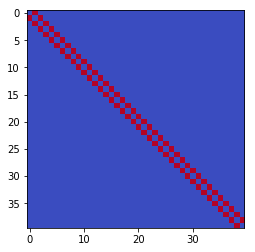

In [16]:
%pylab inline
plt.imshow(a, cmap='coolwarm')

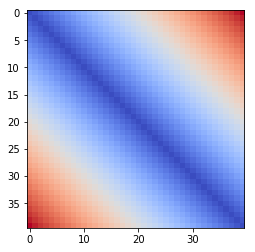

In [17]:
plt.imshow(pd, cmap='coolwarm')

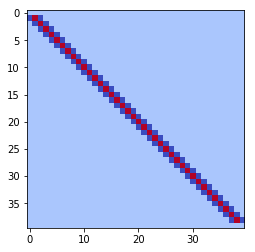

In [18]:
plt.imshow(L, cmap='coolwarm')